# 脳波データ左右半球差分析

このノートブックでは、Muse脳波データの左右半球間の非対称性を詳細に分析します。

## 前提

このノートブックは [mind_monitor_basic_analysis.ipynb](mind_monitor_basic_analysis.ipynb) の続きです。
基本分析で前処理済みのデータを使用します。

## 目次

1. データの読み込みと前処理
2. 左右半球の定義と非対称性指数（AI）
3. 左右差の時系列変化
4. 左右差のヒートマップ
5. 左右差の解釈ガイド
6. 前頭部Alpha非対称性と感情状態

## 関連ノートブック

- [mind_monitor_basic_analysis.ipynb](mind_monitor_basic_analysis.ipynb) - 基本分析
- [fm_theta_analysis.ipynb](fm_theta_analysis.ipynb) - fmシータ波分析

## 1. データの読み込みと前処理

まず、基本分析と同様にデータを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mne
from IPython.display import display

%matplotlib inline

# 日本語フォント設定
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# データファイルのパス
DATA_PATH = Path('../data/samples/mindMonitor_2025-10-17--15-57-54_1095381020592657976.csv')
print(f'Loading: {DATA_PATH}')

# CSVを読み込み
df = pd.read_csv(DATA_PATH)

# タイムスタンプを日時型に変換
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
df = df.dropna(subset=['TimeStamp']).sort_values('TimeStamp').reset_index(drop=True)

# データの先頭を確認
display(df.head())
print(f'\nデータ形状: {df.shape[0]} 行 × {df.shape[1]} 列')
print(f'記録時間: {df["TimeStamp"].min()} ~ {df["TimeStamp"].max()}')
print(f'計測時間: {(df["TimeStamp"].max() - df["TimeStamp"].min()).total_seconds():.1f} 秒')

Loading: ../data/samples/mindMonitor_2025-10-17--15-57-54_1095381020592657976.csv


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Optics15,Optics16,Heart_Rate,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2025-10-17 15:57:54.514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected MuseS-FA35
1,2025-10-17 15:57:54.573,0.654498,-0.316525,0.085821,0.751182,0.42575,-0.29557,-0.076097,0.641183,0.613699,...,0.0,0.0,75.379105,1.0,1.0,1.0,1.0,1.0,-1.0,NaN
2,2025-10-17 15:57:54.573,0.654498,-0.316525,0.085821,0.751182,0.42575,-0.29557,-0.076097,0.641183,0.613699,...,0.0,0.0,75.379105,1.0,1.0,1.0,1.0,1.0,-1.0,NaN
3,2025-10-17 15:57:54.577,0.654498,-0.316525,0.085821,0.751182,0.42575,-0.29557,-0.076097,0.641183,0.613699,...,0.0,0.0,75.379105,1.0,1.0,1.0,1.0,1.0,-1.0,NaN
4,2025-10-17 15:57:54.577,0.654498,-0.316525,0.085821,0.751182,0.42575,-0.29557,-0.076097,0.641183,0.613699,...,0.0,0.0,75.379105,1.0,1.0,1.0,1.0,1.0,-1.0,NaN



データ形状: 353812 行 × 59 列
記録時間: 2025-10-17 15:57:54.514000 ~ 2025-10-17 16:20:47.895000
計測時間: 1373.4 秒


In [3]:
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
summary_rows = []

for band in bands:
    cols = [c for c in df.columns if c.startswith(f'{band}_')]
    if not cols:
        continue
    
    numeric = df[cols].apply(pd.to_numeric, errors='coerce')
    numeric = numeric.replace(0.0, np.nan)  # ゼロは欠損として扱う
    
    summary_rows.append({
        'バンド': band,
        '平均値': numeric.stack().mean(),
        '標準偏差': numeric.stack().std(),
        '有効データ率 (%)': numeric.notna().stack().mean() * 100,
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df.style.format({
    '平均値': '{:.4f}',
    '標準偏差': '{:.4f}',
    '有効データ率 (%)': '{:.2f}'
}))

,バンド,平均値,標準偏差,有効データ率 (%)
0,Delta,-0.1861,0.3674,99.79
1,Theta,-0.0956,0.4094,99.79
2,Alpha,0.9385,0.3045,99.79
3,Beta,0.2015,0.2353,99.79
4,Gamma,0.2630,0.1772,99.79


In [4]:
# RAWチャネルの検出
raw_cols = [c for c in df.columns if c.startswith('RAW_')]

# MNE用にRAWデータを準備
if raw_cols:
    # 数値変換と前処理
    numeric = df[raw_cols].apply(pd.to_numeric, errors='coerce')
    frame = pd.concat([df['TimeStamp'], numeric], axis=1)
    frame = frame.set_index('TimeStamp')
    
    # 重複タイムスタンプは平均化
    frame = frame.groupby(level=0).mean()
    
    # 時間補間で欠損値を埋める
    frame = frame.interpolate(method='time').ffill().bfill()
    
    # サンプリングレートの推定
    diffs = frame.index.to_series().diff().dropna()
    dt_seconds = diffs.median().total_seconds()
    sfreq = 1.0 / dt_seconds if dt_seconds > 0 else 256.0
    
    # MNE RawArrayの作成
    ch_names = list(frame.columns)
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    
    # μVスケールをVに変換
    data = frame.to_numpy().T * 1e-6
    
    raw = mne.io.RawArray(data, info, copy='auto', verbose=False)
    
    # DCドリフト軽減のためのハイパスフィルタ
    if sfreq > 2.0:
        raw = raw.filter(l_freq=1.0, h_freq=None, fir_design='firwin', verbose=False)
    
    print(f'検出されたチャネル: {ch_names}')
    print(f'推定サンプリングレート: {sfreq:.2f} Hz')
    print(f'サンプル数: {len(frame)}')
else:
    print('RAWチャネルが見つかりません')

検出されたチャネル: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
推定サンプリングレート: 250.00 Hz
サンプル数: 73379


## 7. 左右半球差分析

脳の左右半球間のバンドパワーの違いを分析します。

### 7.1 左右半球の定義

- **左半球**: TP9（左側頭部）、AF7（左前頭部）
- **右半球**: TP10（右側頭部）、AF8（右前頭部）

### 7.2 左右差指標

左右差は以下のように計算します：
- **非対称性指数 (AI)**: (右 - 左) / (右 + 左) × 100
  - 正の値：右半球優位
  - 負の値：左半球優位
  - ±10%以内：概ね対称

In [5]:
# 左右差の計算
laterality_df = pd.DataFrame({'TimeStamp': df['TimeStamp']})

# 電極ペアの定義
electrode_pairs = [
    ('TP9', 'TP10', '側頭部'),   # 左右側頭部
    ('AF7', 'AF8', '前頭部'),     # 左右前頭部
]

asymmetry_data = []

for band in bands:
    for left_electrode, right_electrode, region in electrode_pairs:
        left_col = f'{band}_{left_electrode}'
        right_col = f'{band}_{right_electrode}'
        
        if left_col in df.columns and right_col in df.columns:
            left_vals = pd.to_numeric(df[left_col], errors='coerce')
            right_vals = pd.to_numeric(df[right_col], errors='coerce')
            
            # 非対称性指数の計算
            # AI = (R - L) / (R + L) × 100
            sum_vals = right_vals + left_vals
            ai = ((right_vals - left_vals) / sum_vals * 100).replace([np.inf, -np.inf], np.nan)
            
            col_name = f'{band}_{region}_AI'
            laterality_df[col_name] = ai
            
            # 統計情報を収集
            valid_ai = ai.dropna()
            if len(valid_ai) > 0:
                asymmetry_data.append({
                    'バンド': band,
                    '領域': region,
                    '平均AI (%)': valid_ai.mean(),
                    '中央AI (%)': valid_ai.median(),
                    '標準偏差': valid_ai.std(),
                    '優位性': '右優位' if valid_ai.mean() > 10 else '左優位' if valid_ai.mean() < -10 else '対称',
                })

# 統計サマリー表示
asymmetry_summary = pd.DataFrame(asymmetry_data)
display(asymmetry_summary.style.format({
    '平均AI (%)': '{:.2f}',
    '中央AI (%)': '{:.2f}',
    '標準偏差': '{:.2f}',
}))

,バンド,領域,平均AI (%),中央AI (%),標準偏差,優位性
0,Delta,側頭部,-167.64,-5.85,11059.59,左優位
1,Delta,前頭部,-3.00,-2.96,457.87,対称
2,Theta,側頭部,337.39,15.38,34223.25,右優位
3,Theta,前頭部,-19.34,-8.71,2654.00,左優位
4,Alpha,側頭部,2.37,3.10,8.57,対称
5,Alpha,前頭部,8.91,8.63,8.39,対称
6,Beta,側頭部,23.36,14.33,2386.62,右優位
7,Beta,前頭部,-72.10,12.31,8620.88,左優位
8,Gamma,側頭部,17.83,5.75,2108.92,右優位
9,Gamma,前頭部,34.07,18.74,1216.83,右優位


### 7.3 左右差の時系列変化

各周波数バンドの左右差が時間とともにどう変化するかを観察します。

In [6]:
# 移動平均でスムージング
laterality_smooth = laterality_df.copy()
for col in laterality_df.columns[1:]:
    laterality_smooth[f'{col}_smooth'] = laterality_df[col].rolling(
        window=rolling_window, min_periods=1
    ).median()

# バンドごとにプロット
fig, axes = plt.subplots(len(bands), 1, figsize=(14, 12), sharex=True)
if len(bands) == 1:
    axes = [axes]

colors_regions = {'側頭部': 'blue', '前頭部': 'red'}

for idx, band in enumerate(bands):
    ax = axes[idx]
    
    for left_electrode, right_electrode, region in electrode_pairs:
        col_smooth = f'{band}_{region}_AI_smooth'
        if col_smooth in laterality_smooth.columns:
            ax.plot(
                laterality_smooth['TimeStamp'],
                laterality_smooth[col_smooth],
                label=region,
                color=colors_regions.get(region, 'gray'),
                linewidth=2,
                alpha=0.8
            )
    
    # 基準線
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax.axhline(y=10, color='gray', linestyle='--', alpha=0.3, linewidth=1, label='±10% (対称範囲)')
    ax.axhline(y=-10, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_ylabel(f'{band}\nAI (%)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-100, 100)
    
    # 右優位・左優位のラベル
    ax.text(0.99, 0.95, '右優位', transform=ax.transAxes, 
           verticalalignment='top', horizontalalignment='right',
           fontsize=9, alpha=0.5)
    ax.text(0.99, 0.05, '左優位', transform=ax.transAxes,
           verticalalignment='bottom', horizontalalignment='right',
           fontsize=9, alpha=0.5)

axes[0].set_title('左右半球非対称性の時間推移', fontsize=14, fontweight='bold')
axes[-1].set_xlabel('時刻', fontsize=12)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

NameError: name 'rolling_window' is not defined

### 7.4 左右差のヒートマップ

各バンドと領域の組み合わせにおける左右差の全体像を可視化します。

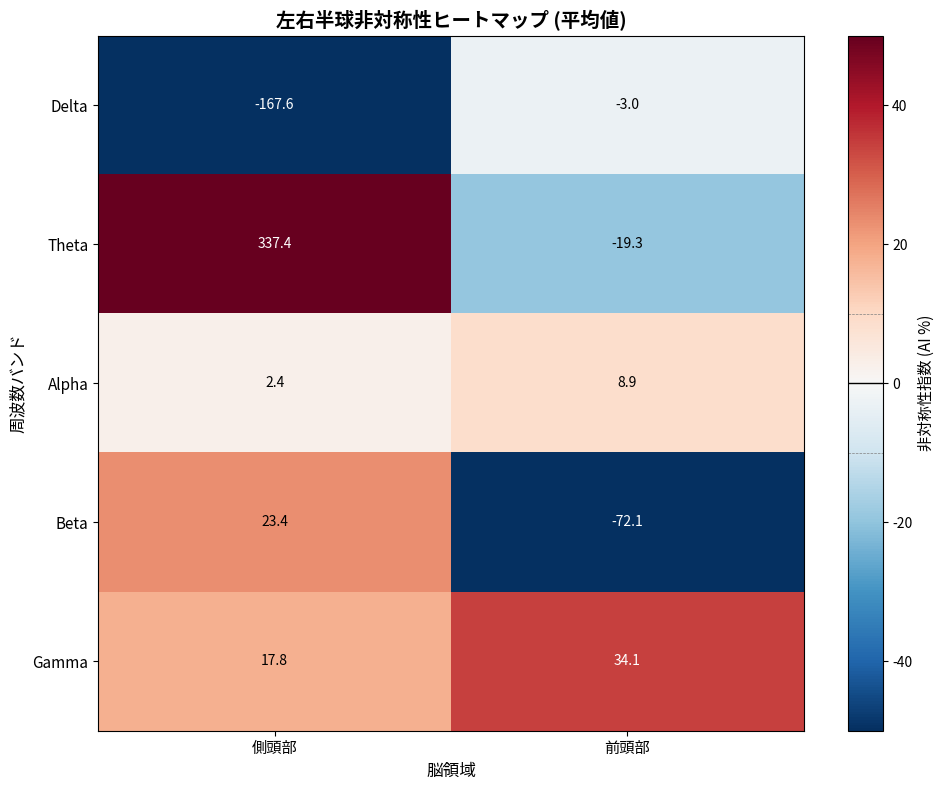


=== 左右差の解釈 ===
正の値（赤）: 右半球優位
負の値（青）: 左半球優位
±10%以内（白）: 概ね対称

一般的な傾向:
- 左前頭部Alpha↑: ポジティブ感情
- 右前頭部Alpha↑: ネガティブ感情・回避行動
- 左半球Beta↑: 言語処理・論理的思考
- 右半球Beta↑: 空間認識・創造的思考


In [ ]:
# ヒートマップ用データの準備
heatmap_data = []
for band in bands:
    row = []
    for left_electrode, right_electrode, region in electrode_pairs:
        col = f'{band}_{region}_AI'
        if col in laterality_df.columns:
            mean_ai = laterality_df[col].dropna().mean()
            row.append(mean_ai)
        else:
            row.append(np.nan)
    heatmap_data.append(row)

heatmap_array = np.array(heatmap_data)
region_labels = [region for left_electrode, right_electrode, region in electrode_pairs]

# ヒートマップのプロット
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heatmap_array, cmap='RdBu_r', aspect='auto', vmin=-50, vmax=50)

# 軸ラベル設定
ax.set_xticks(np.arange(len(region_labels)))
ax.set_yticks(np.arange(len(bands)))
ax.set_xticklabels(region_labels, fontsize=11)
ax.set_yticklabels(bands, fontsize=11)

# セルに数値を表示
for i in range(len(bands)):
    for j in range(len(region_labels)):
        value = heatmap_array[i, j]
        if not np.isnan(value):
            text_color = 'white' if abs(value) > 25 else 'black'
            text = ax.text(j, i, f'{value:.1f}',
                          ha='center', va='center', color=text_color, fontsize=10)

# カラーバー
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('非対称性指数 (AI %)', fontsize=11)
cbar.ax.axhline(y=0, color='black', linewidth=1)
cbar.ax.axhline(y=10, color='gray', linestyle='--', linewidth=0.5)
cbar.ax.axhline(y=-10, color='gray', linestyle='--', linewidth=0.5)

ax.set_title('左右半球非対称性ヒートマップ (平均値)', fontsize=14, fontweight='bold')
ax.set_xlabel('脳領域', fontsize=12)
ax.set_ylabel('周波数バンド', fontsize=12)

plt.tight_layout()
plt.show()

# 解釈のヒント
print('\n=== 左右差の解釈 ===')
print('正の値（赤）: 右半球優位')
print('負の値（青）: 左半球優位')
print('±10%以内（白）: 概ね対称')
print('\n一般的な傾向:')
print('- 左前頭部Alpha↑: ポジティブ感情')
print('- 右前頭部Alpha↑: ネガティブ感情・回避行動')
print('- 左半球Beta↑: 言語処理・論理的思考')
print('- 右半球Beta↑: 空間認識・創造的思考')

### 7.5 左右差の解釈ガイド

このデータの左右差パターンから何が読み取れるかを解釈します。

In [ ]:
# 解釈用のサマリーを作成
interpretation_data = []

for band in bands:
    for left_electrode, right_electrode, region in electrode_pairs:
        col = f'{band}_{region}_AI'
        if col in laterality_df.columns:
            ai_values = laterality_df[col].dropna()
            mean_ai = ai_values.mean()
            
            # 優位性の判定
            if abs(mean_ai) < 10:
                dominance = '対称'
                interpretation = '左右バランスが取れている'
            elif mean_ai > 10:
                dominance = f'右優位 ({right_electrode})'
                interpretation = f'{right_electrode}側の活動が顕著'
            else:
                dominance = f'左優位 ({left_electrode})'
                interpretation = f'{left_electrode}側の活動が顕著'
            
            # バンド・領域特有の解釈を追加
            specific_meaning = ''
            
            # Alpha波の前頭部非対称性（感情的アプローチ）
            if band == 'Alpha' and region == '前頭部':
                if mean_ai < -10:
                    specific_meaning = '→ 接近・ポジティブ感情傾向'
                elif mean_ai > 10:
                    specific_meaning = '→ 回避・ネガティブ感情傾向'
                else:
                    specific_meaning = '→ 感情的に中立'
            
            # Beta波（認知処理）
            elif band == 'Beta':
                if region == '前頭部':
                    if mean_ai < -10:
                        specific_meaning = '→ 言語処理・分析的思考優位'
                    elif mean_ai > 10:
                        specific_meaning = '→ 空間認識・直感的思考優位'
                elif region == '側頭部':
                    if abs(mean_ai) > 20:
                        specific_meaning = '→ 感覚処理の非対称性'
            
            # Theta波（瞑想・創造性）
            elif band == 'Theta' and region == '前頭部':
                if abs(mean_ai) > 15:
                    specific_meaning = '→ 瞑想状態に左右差あり'
            
            # Gamma波（高次認知）
            elif band == 'Gamma':
                if abs(mean_ai) > 20:
                    specific_meaning = '→ 高次認知処理の偏り'
            
            interpretation_data.append({
                'バンド': band,
                '領域': region,
                '平均AI': f'{mean_ai:+.1f}%',
                '優位性': dominance,
                '基本解釈': interpretation,
                '詳細': specific_meaning if specific_meaning else '-'
            })

interpretation_df = pd.DataFrame(interpretation_data)
display(interpretation_df)

print('\n=== このデータから読み取れること ===')
print()

# 前頭部Alpha非対称性のチェック
alpha_frontal = laterality_df.get('Alpha_前頭部_AI', pd.Series([np.nan]))
alpha_frontal_mean = alpha_frontal.dropna().mean()
print(f'1. 前頭部Alpha非対称性: {alpha_frontal_mean:+.1f}%')
if alpha_frontal_mean < -10:
    print('   → 左前頭部が優位 = 接近動機・ポジティブ感情が高い状態')
elif alpha_frontal_mean > 10:
    print('   → 右前頭部が優位 = 回避動機・ネガティブ感情/不安傾向')
else:
    print('   → 感情的にバランスの取れた状態')

print()

# Beta波のチェック
beta_frontal = laterality_df.get('Beta_前頭部_AI', pd.Series([np.nan]))
beta_frontal_mean = beta_frontal.dropna().mean()
print(f'2. 前頭部Beta非対称性: {beta_frontal_mean:+.1f}%')
if abs(beta_frontal_mean) > 20:
    if beta_frontal_mean < 0:
        print('   → 左脳優位 = 言語処理・論理的思考が活発')
    else:
        print('   → 右脳優位 = 空間認識・創造的思考が活発')
else:
    print('   → 認知処理のバランスが良い')

print()
print('3. 注意点:')
print('   - 極端な非対称性（|AI| > 100%）は測定誤差の可能性')
print('   - ヘッドバンドの装着位置のズレでも左右差は生じます')
print('   - 一時的な筋電ノイズ（瞬き、顎の緊張）の影響も考慮を')

,バンド,領域,平均AI,優位性,基本解釈,詳細
0,Delta,側頭部,-167.6%,左優位 (TP9),TP9側の活動が顕著,-
1,Delta,前頭部,-3.0%,対称,左右バランスが取れている,-
2,Theta,側頭部,+337.4%,右優位 (TP10),TP10側の活動が顕著,-
3,Theta,前頭部,-19.3%,左優位 (AF7),AF7側の活動が顕著,→ 瞑想状態に左右差あり
4,Alpha,側頭部,+2.4%,対称,左右バランスが取れている,-
5,Alpha,前頭部,+8.9%,対称,左右バランスが取れている,→ 感情的に中立
6,Beta,側頭部,+23.4%,右優位 (TP10),TP10側の活動が顕著,→ 感覚処理の非対称性
7,Beta,前頭部,-72.1%,左優位 (AF7),AF7側の活動が顕著,→ 言語処理・分析的思考優位
8,Gamma,側頭部,+17.8%,右優位 (TP10),TP10側の活動が顕著,-
9,Gamma,前頭部,+34.1%,右優位 (AF8),AF8側の活動が顕著,→ 高次認知処理の偏り



=== このデータから読み取れること ===

1. 前頭部Alpha非対称性: +8.9%
   → 感情的にバランスの取れた状態

2. 前頭部Beta非対称性: -72.1%
   → 左脳優位 = 言語処理・論理的思考が活発

3. 注意点:
   - 極端な非対称性（|AI| > 100%）は測定誤差の可能性
   - ヘッドバンドの装着位置のズレでも左右差は生じます
   - 一時的な筋電ノイズ（瞬き、顎の緊張）の影響も考慮を


### 7.6 前頭部Alpha非対称性と感情状態

前頭部Alpha波の左右差は、感情状態や動機づけと関連していることが知られています。
時間経過とともに感情状態がどう変化したかを詳しく見てみましょう。

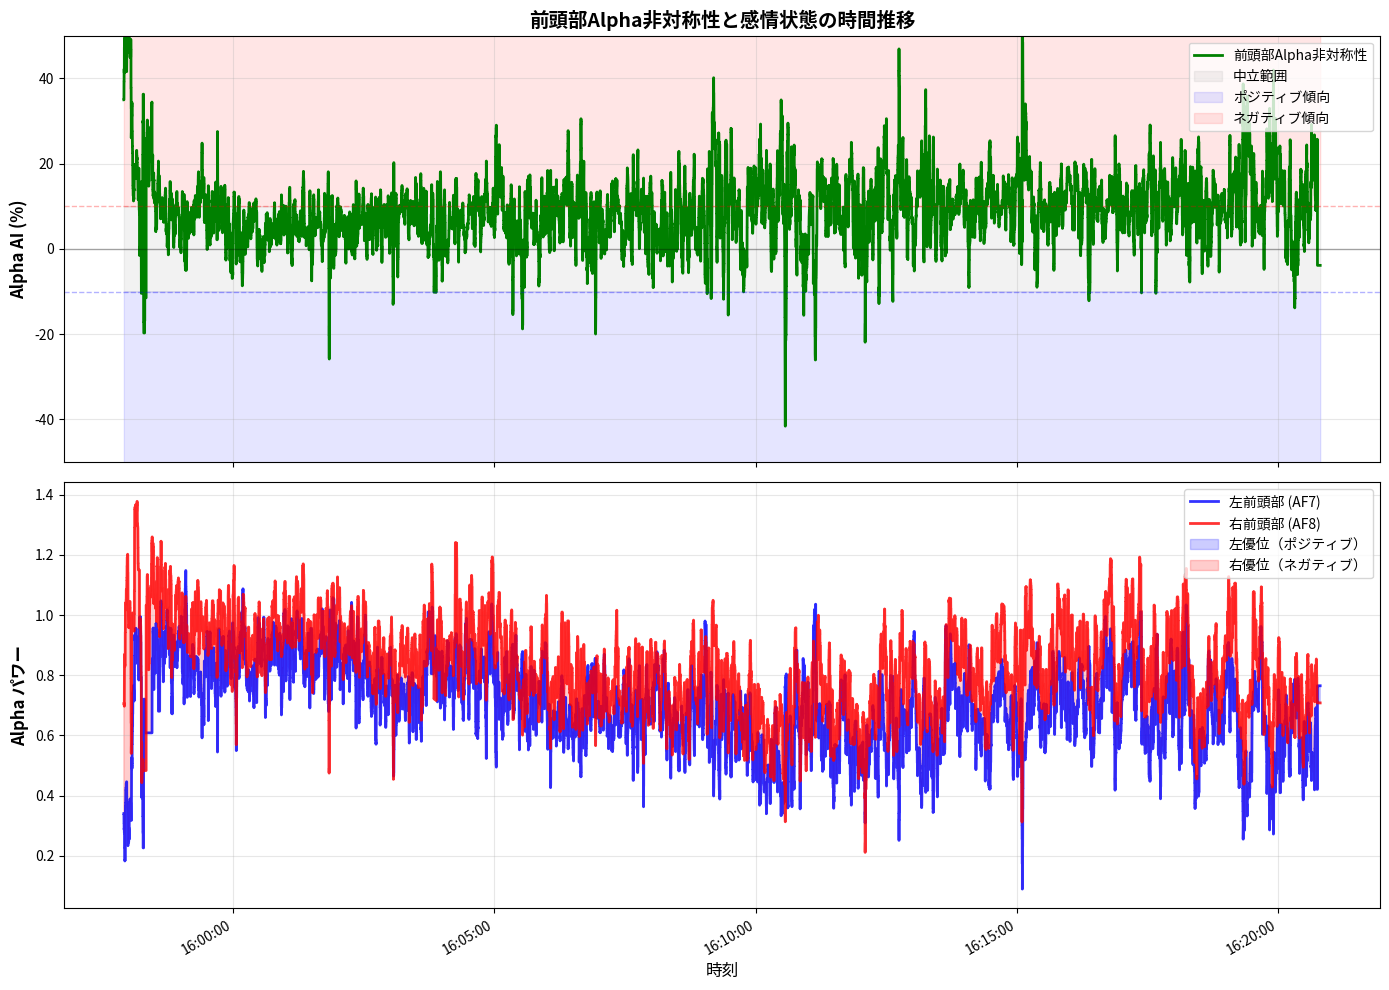


=== 感情状態の分布 ===
中立: 202,411 サンプル (57.2%)
ネガティブ傾向: 123,998 サンプル (35.0%)
強いネガティブ傾向: 23,725 サンプル (6.7%)
ポジティブ傾向: 3,007 サンプル (0.8%)
強いポジティブ傾向: 670 サンプル (0.2%)
Unknown: 1 サンプル (0.0%)

平均Alpha AI: +8.9%
標準偏差: 8.4%

=== 総合的な感情傾向 ===
○ セッション全体として、感情的にバランスの取れた状態
  左右の活動が均衡 → 中立的、落ち着いた状態


In [ ]:
# 前頭部Alpha非対称性の詳細分析
if 'Alpha_前頭部_AI' in laterality_df.columns:
    alpha_ai = laterality_df[['TimeStamp', 'Alpha_前頭部_AI']].copy()
    alpha_ai['Alpha_AI_smooth'] = alpha_ai['Alpha_前頭部_AI'].rolling(
        window=rolling_window, min_periods=1
    ).median()
    
    # 感情状態のカテゴリ化
    def categorize_emotion(ai_value):
        if pd.isna(ai_value):
            return 'Unknown'
        elif ai_value < -20:
            return '強いポジティブ傾向'
        elif ai_value < -10:
            return 'ポジティブ傾向'
        elif ai_value < 10:
            return '中立'
        elif ai_value < 20:
            return 'ネガティブ傾向'
        else:
            return '強いネガティブ傾向'
    
    alpha_ai['感情状態'] = alpha_ai['Alpha_AI_smooth'].apply(categorize_emotion)
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # 上段: Alpha AIの時系列
    ax1.plot(alpha_ai['TimeStamp'], alpha_ai['Alpha_AI_smooth'], 
            color='green', linewidth=2, label='前頭部Alpha非対称性')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax1.axhline(y=-10, color='blue', linestyle='--', alpha=0.3, linewidth=1)
    ax1.axhline(y=10, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax1.fill_between(alpha_ai['TimeStamp'], -10, 10, alpha=0.1, color='gray', label='中立範囲')
    ax1.fill_between(alpha_ai['TimeStamp'], -100, -10, alpha=0.1, color='blue', label='ポジティブ傾向')
    ax1.fill_between(alpha_ai['TimeStamp'], 10, 100, alpha=0.1, color='red', label='ネガティブ傾向')
    
    ax1.set_ylabel('Alpha AI (%)', fontsize=12, fontweight='bold')
    ax1.set_title('前頭部Alpha非対称性と感情状態の時間推移', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-50, 50)
    
    # 下段: 左右のAlpha波パワー比較
    if 'Alpha_AF7' in df.columns and 'Alpha_AF8' in df.columns:
        alpha_left = pd.to_numeric(df['Alpha_AF7'], errors='coerce').rolling(
            window=rolling_window, min_periods=1
        ).median()
        alpha_right = pd.to_numeric(df['Alpha_AF8'], errors='coerce').rolling(
            window=rolling_window, min_periods=1
        ).median()
        
        ax2.plot(df['TimeStamp'], alpha_left, color='blue', linewidth=2, 
                label='左前頭部 (AF7)', alpha=0.8)
        ax2.plot(df['TimeStamp'], alpha_right, color='red', linewidth=2, 
                label='右前頭部 (AF8)', alpha=0.8)
        ax2.fill_between(df['TimeStamp'], alpha_left, alpha_right, 
                        where=(alpha_left > alpha_right), 
                        color='blue', alpha=0.2, label='左優位（ポジティブ）')
        ax2.fill_between(df['TimeStamp'], alpha_left, alpha_right, 
                        where=(alpha_left <= alpha_right), 
                        color='red', alpha=0.2, label='右優位（ネガティブ）')
        
        ax2.set_ylabel('Alpha パワー', fontsize=12, fontweight='bold')
        ax2.set_xlabel('時刻', fontsize=12)
        ax2.legend(loc='upper right', fontsize=10)
        ax2.grid(True, alpha=0.3)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    
    # 統計サマリー
    print('\n=== 感情状態の分布 ===')
    emotion_counts = alpha_ai['感情状態'].value_counts()
    total = len(alpha_ai.dropna(subset=['Alpha_AI_smooth']))
    for emotion, count in emotion_counts.items():
        percentage = count / total * 100
        print(f'{emotion}: {count:,} サンプル ({percentage:.1f}%)')
    
    print(f'\n平均Alpha AI: {alpha_ai["Alpha_AI_smooth"].mean():+.1f}%')
    print(f'標準偏差: {alpha_ai["Alpha_AI_smooth"].std():.1f}%')
    
    # 解釈
    mean_alpha_ai = alpha_ai['Alpha_AI_smooth'].mean()
    print('\n=== 総合的な感情傾向 ===')
    if mean_alpha_ai < -10:
        print('✓ セッション全体として、ポジティブで接近的な感情状態が優勢')
        print('  左前頭部の活動が活発 → 好奇心、意欲、前向きな気分')
    elif mean_alpha_ai > 10:
        print('⚠ セッション全体として、ネガティブで回避的な感情状態が優勢')
        print('  右前頭部の活動が活発 → 不安、心配、回避傾向')
    else:
        print('○ セッション全体として、感情的にバランスの取れた状態')
        print('  左右の活動が均衡 → 中立的、落ち着いた状態')
else:
    print('前頭部Alpha非対称性データが見つかりません')